Análise de Incidentes de Violência Armada nos EUA

A violência armada nos EUA resulta em dezenas de milhares de mortes e ferimentos anualmente. Em 2013, houve 73.505 ferimentos de armas de fogo não fatais, incluindo 11.208 homicídios, 21.175 suicídios, 505 mortes por descarga acidental ou negligência de arma de fogo e 281 mortes por uso de armas de fogo com “intenção indeterminada”. Neste caderno, realizei uma profunda exploração deste conjunto de dados de incidentes de violência armada relatados nos EUA desde 2013.

1. Preparação do Conjunto de Dados

Como primeira etapa, vamos importar as bibliotecas necessárias, carregar o conjunto de dados e criar alguns recursos adicionais.

In [1]:
# Import the required libraries 
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from textblob import TextBlob 
import plotly.plotly as py
from plotly import tools
import seaborn as sns
import pandas as pd
import string, os, random
import calendar
from PIL import Image 
import numpy as np

import folium 
from folium import plugins 


init_notebook_mode(connected=True)
punc = string.punctuation
from datetime import datetime

# Load the dataset
path = 'C:\\Users\\Jonathan\\gun-violence-data_01-2013_03-2018.csv'
# path = "input/gun-violence-data_01-2013_03-2018.csv"
df = pd.read_csv(path)


### Fix a row in the dataset 
### According to the author of this dataset, one particular incident is missing from the dataset 
### I have manually added this incident
### Related Thread: https://www.kaggle.com/jameslko/gun-violence-data/discussion/55307
missing_row = ['sban_1', '2017-10-01', 'Nevada', 'Las Vegas', 'Mandalay Bay 3950 Blvd S', 59, 489, 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', '-', '-', '-', '-', '-', '36.095', 'Hotel', 
               '-115.171667', 47, 'Route 91 Harvest Festiva; concert, open fire from 32nd floor. 47 guns seized; TOTAL:59 kill, 489 inj, number shot TBD,girlfriend Marilou Danley POI', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
df.loc[len(df)] = missing_row

# Create some additional features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['monthday'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['loss'] = df['n_killed'] + df['n_injured']

2. Explorando tendências relacionadas a violência armada no decorrer do ano.

Nesta seção, analisarei as tendências relacionadas a incidentes de violência armada. Isso inclui o número de incidentes ocorridos por ano, meses, dias da semana, etc.

2.1 Número de incidentes de violência armada por ano.

Vamos traçar o número de incidentes de violência armada por ano. Eu não incluí os dados dos anos de 2014 em diante.

In [2]:
# function to aggregate and return keys and values
def create_stack_bar_data(col):
    aggregated = df[col].value_counts()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

x1, y1 = create_stack_bar_data('year')
x1 = x1[:-1]
y1 = y1[:-1]
trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="year count", marker=dict(color=['rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(10, 220, 150, 0.6)', 'rgba(222,45,38,0.8)']))
layout = dict(height=400, title='Gun Violence Incidents by year', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Com base no gráfico acima, podemos observar que o número de incidentes de violência armada está aumentando a cada ano. No ano de 2014, houve cerca de 51 mil incidentes relatados, o número aumentou para 53 mil no próximo ano, 2016 registrou um salto maior com quase 58 mil incidentes reportados, em 2017, o número de incidentes de violência armada aumentou ainda mais para 61 mil. Um grande aumento de 10.000 incidentes foi observado de 2014 a 2017. Ainda estamos no meio do caminho em 2018 e espera-se que esse número cresça ainda mais.

2.2 Número médio de incidentes por mês
Permite obter o número médio de incidentes por mês.

In [3]:
tempdf = df[df['year'].isin(['2014','2015','2016','2017'])]
tempdf1 = tempdf.groupby(['year','month']).agg({'month' : 'count'}).rename(columns={'month': 'month_count'}).reset_index()
aggregated = tempdf1.groupby(['month']).agg({'month_count' : 'mean'})
x2 = aggregated.index.tolist()
y2 = aggregated.month_count.tolist()
mapp = {}
for m,v in zip(x2, y2):
    mapp[m] = v
xn = [calendar.month_abbr[int(x)] for x in sorted(x2)]
vn = [mapp[x] for x in sorted(x2)]

trace1 = go.Bar(x=xn, y=vn, opacity=0.75, name="month", marker=dict(color='rgba(100, 20, 10, 0.6)'))
layout = dict(height=400, title='Average number of Incidents by Months', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig, filename='stacked-bar')

Os meses de julho e agosto têm o maior número médio de incidentes de violência armada do que qualquer outro mês. Nestes dois meses, há cerca de 5200 incidentes relatados a cada ano. O Feburary tem o menor número de incidentes médios, cerca de 3700 por ano. Em algumas próximas seções, tentarei explorar se há alguma data específica em que o número de incidentes de violência armada é sempre maior.

2.3 Número médio de incidentes de violência armada por dia da semana

In [4]:
tempdf1 = df.groupby(['year', 'weekday']).agg({'weekday' : 'count'}).rename(columns={'weekday' : 'weekday_count'}).reset_index()
aggregated = tempdf1.groupby(['weekday']).agg({'weekday_count' : 'mean'})

x2 = aggregated.index.tolist()
y2 = aggregated.weekday_count.tolist()

weekmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
x2 = [weekmap[x] for x in x2]
wkmp = {}
for j,x in enumerate(x2):
    wkmp[x] = y2[j]
order = list(weekmap.values())
ordervals = [wkmp[val] for val in order]

trace1 = go.Bar(x=order, y=ordervals, opacity=0.75, name="weekday", marker=dict(color='rgba(61, 60, 250, 0.6)'))
layout = dict(height=400, title='Average number of by Day of the Week', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig, filename='stacked-bar')

O número de incidentes de violência armada é maior nos finais de semana, com aproximadamente 6000 incidentes aos sábados e domingos nos EUA.

2.4 Lote de Séries Temporais do Total de Incidentes, Pessoas Mortas, Pessoas Feridas

In [5]:
# 2014 time series
temp = df[df['year'] == 2014].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2014', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)



# 2015 time series
temp = df[df['year'] == 2015].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350, title = 'Gun Violence Incidents - 2015', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)





# 2016 time series
temp = df[df['year'] == 2016].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350,title = 'Gun Violence Incidents - 2016', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)


# 2017 time series
temp = df[df['year'] == 2017].groupby('date').agg({'state' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}).reset_index().rename(columns={'state' : 'incidents'})


trace1 = go.Scatter(x = temp.date, y = temp.incidents, name='Total Incidents', mode = "lines", marker = dict(color = '#c5d9f9'))
trace2 = go.Scatter(x = temp.date, y = temp.n_killed, name="Total Killed", mode = "lines", marker = dict(color = '#ff9f87'))
trace3 = go.Scatter(x = temp.date, y = temp.n_injured, name="Total Injured", mode = "lines", marker = dict(color = '#e8baff'))

data = [trace1, trace2, trace3]
layout = dict(height=350,title = 'Gun Violence Incidents - 2017', legend=dict(orientation="h", x=-.01, y=1), xaxis= dict(title='Date Time', ticklen= 1))
fig = dict(data = data, layout = layout)
iplot(fig)

4 de julho - data mais perigosa

A partir dos gráficos acima, podemos observar os picos mais altos em torno de 4 de julho e 5 de julho de 2014 a 2017. Isso é muito interessante, pois o dia 4 de julho é comemorado como o Dia da Independência nos Estados Unidos da América. A partir destes dados, parece que 04 de julho - 05 de julho são as datas relacionadas com um número muito grande de incidentes de violência armada, portanto, são as datas mais perigosas. O feriado também pode contribuir para o fato de que um grande número de incidentes de violência armada é relatado.


4 de julho de 2014: Total de Incidentes: 192, Total de Danos: 92, Total de Mortos: 48
4 de julho de 2015: Total de Incidentes: 211, Total de Danos: 142, Total de Mortos: 60
4 de julho de 2016: Total de Incidentes: 224, Total de Danos: 163, Total de Mortos: 52
4 de Julho de 2017: Total de Incidentes: 248, Total de Danos: 146, Total de Mortos: 62

                
Referências:

https://www.theguardian.com/world/2014/jul/07/gun-violence-fourth-of-july-weekend

https://www.cbsnews.com/news/chicago-violence-fourth-of-july-weekend-shootings/


Uma tendência semelhante é observada em 5 de julho, que é o dia seguinte do Dia da Independência.

5 de julho de 2014 - 212 incidentes
5 de julho de 2015 - 211 incidentes
5 de julho de 2016 - 224 incidentes
5 de julho de 2017 - 248 incidentes



Depois de observar esta tendência em um dos feriados importantes dos EUA, estou curioso para obter esses números em outros feriados. Depois de investigar os feriados importantes dos EUA, ou seja, Natal, Dia de Ação de Graças, Dia do Trabalhador, pode-se ver que o número de incidentes de violência armada também é significativamente maior.

3. Explorando tendências relacionadas à localização

    3.1 Número de incidentes por estado

In [6]:
states_df = df['state'].value_counts()

statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state_to_code = {'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI', 'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 'Nevada': 'NV', 'Maine': 'ME'}
statesdf['state_code'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = statesdf['state_code'],
        z = statesdf['counts'],
        locationmode = 'USA-states',
        text = statesdf['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Gun Violence Incidents")
        ) ]

layout = dict(
        title = 'State wise number of Gun Violence Incidents',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

# data = [ dict(
#         type='choropleth',
#         colorscale = scl,
#         autocolorscale = False,
#         locations = statesdf['state_code'],
#         z = statesdf['counts'],
#         locationmode = 'USA-states',
#         text = statesdf['state'],
#         marker = dict(
#             line = dict (
#                 color = 'rgb(255,255,255)',
#                 width = 2
#             ) ),
#         colorbar = dict(
#             title = "Gun Violence Incidents")
#         ) ]

# layout = dict(
#         title = 'State wise number of Gun Violence Incidents',
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showlakes = True,
#             lakecolor = 'rgb(255, 255, 255)'),
#              )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

Do mapa acima, o estado Illinoies tem o maior número de incidentes de violência armada relatados nos últimos 5 anos, o número é igual a 17.000. Ele é seguido pela Califórnia com aproximadamente 16.000 incidentes relatados, Flórida com 15.000 incidentes e Texas com 13.000 incidentes de violência armada. Na próxima seção, explorei os estados com os maiores incidentes de violência armada por 100.000 pessoas.

    3.2 Perda Total (Feridos + Mortos) por todos os estados

In [7]:
statdf = df.reset_index().groupby(by=['state']).agg({'loss':'sum', 'year':'count'}).rename(columns={'year':'count'})
statdf['state'] = statdf.index

trace1 = go.Bar(
    x=statdf['state'],
    y=statdf['count'],
    name='Count of Incidents',
    marker=dict(color='rgb(255,10,225)'),
    opacity=0.6
)
trace2 = go.Bar(
    x=statdf['state'],
    y=statdf['loss'],
    name='Total Loss',
    marker=dict(color='rgb(58,22,225)'),
    opacity=0.6
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    margin=dict(b=150),
    legend=dict(dict(x=-.1, y=1.2)),
    title = 'State wise number of Gun Violence Incidents and Total Loss',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

Conjunto de dados ajustado por população

A análise acima foi centrada em torno de números absolutos de incidentes e os principais locais, mas para uma análise melhor, é necessário um conjunto de dados ajustado pela população. Eu adicionei o conjunto de dados da população das 1000 principais cidades obtidas no site a seguir e adicionei alguns novos recursos ajustados à população. Obrigado a @doyouevendata por sugerir.

http://www.biggestuscities.com/top-1000

http://www.enchantedlearning.com/usa/states/population.shtml


    3.3 Incidentes por 100.000 pessoas por estado
    
Vamos explorar quantos incidentes de violência armada ocorrem em diferentes estados por 100.000 pessoas. Além disso, vamos identificar os estados:

In [8]:
census_2013 = {'Mississippi': 2991207, 'Iowa': 3090416, 'Oklahoma': 3850568, 'Delaware': 925749, 'Minnesota': 5420380, 'Alaska': 735132, 'Illinois': 12882135, 'Arkansas': 2959373, 'New Mexico': 2085287, 'Indiana': 6570902, 'Maryland': 5928814, 'Louisiana': 4625470, 'Texas': 26448193, 'Wyoming': 582658, 'Arizona': 6626624, 'Wisconsin': 5742713, 'Michigan': 9895622, 'Kansas': 2893957, 'Utah': 2900872, 'Virginia': 8260405, 'Oregon': 3930065, 'Connecticut': 3596080, 'New York': 19651127, 'California': 38332521, 'Massachusetts': 6692824, 'West Virginia': 1854304, 'South Carolina': 4774839, 'New Hampshire': 1323459, 'Vermont': 626630, 'Georgia': 9992167, 'North Dakota': 723393, 'Pennsylvania': 12773801, 'Florida': 19552860, 'Hawaii': 1404054, 'Kentucky': 4395295, 'Rhode Island': 1051511, 'Nebraska': 1868516, 'Missouri': 6044171, 'Ohio': 11570808, 'Alabama': 4833722, 'South Dakota': 844877, 'Colorado': 5268367, 'Idaho': 1612136, 'New Jersey': 8899339, 'Washington': 6971406, 'North Carolina': 9848060, 'Tennessee': 6495978, 'Montana': 1015165, 'District of Columbia': 646449, 'Nevada': 2790136, 'Maine': 1328302}
statesdf['population'] = statesdf['state'].apply(lambda x : census_2013[x])
statesdf['incidents_per_k'] = statesdf.apply(lambda x : float(x['counts'])*100000 / x['population'], axis=1)
tempdf = statesdf.sort_values('incidents_per_k', ascending = False)[1:50]
trace1 = go.Bar(
    x=tempdf.state,
    y=tempdf.incidents_per_k,
    name='Location Types',
    orientation = 'v',
    marker=dict(color='red'),
    opacity=0.7
)

data = [trace1]
layout = go.Layout(
    height=400,
    margin=dict(b=150),
    barmode='group',
    legend=dict(dict(x=-.1, y=1.2)),
    title = 'Gun Violence Incidents Per 100,000 people by State',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

O Alasca tem o maior número de incidentes de violência armada por 100.000 pessoas aprox. igual a 183, enquanto Arizona, Utha e Idaho são os estados com menor número de incidentes no conjunto de dados ajustados à população. Interessante ver que a Califórnia, que é um dos principais estados com alto número de incidentes de violência armada, tem muito baixa por 100.000 incidentes. Illinois ainda está entre os 5 principais estados com a maioria dos incidentes de violência armada.

    3.4 Conjuntos de dados ajustados à população - Principais cidades (Incidentes por 100.000 pessoas

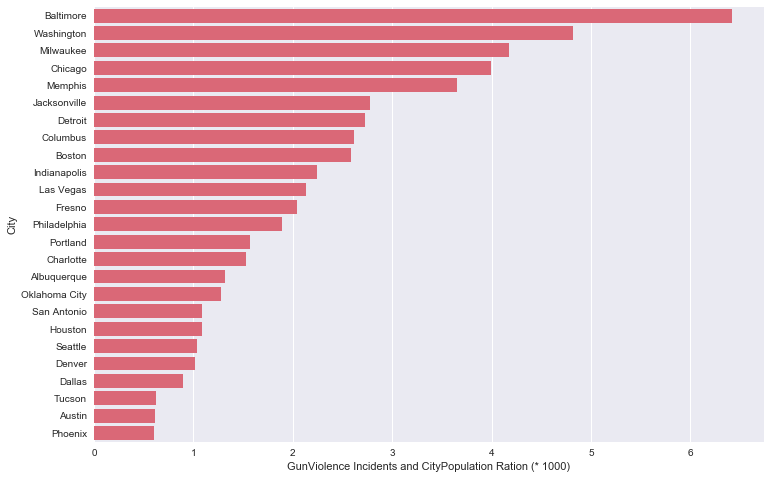

In [9]:
population = {'Carol Stream': '40069', 'La Quinta': '40956', 'Leander': '42761', 'Edinburg': '87650', 'Chino Hills': '78822', 'Pinellas Park': '52137', 'Pacifica': '39062', 'San Luis Obispo': '47536', 'Apache Junction': '39954', 'Toledo': '278508', 'Nampa': '91382', 'Jurupa Valley': '103541', 'Renton': '100953', 'Joplin': '52195', 'Pomona': '152494', 'Hoover': '84978', 'Columbia': '134309', 'Maple Grove': '69576', 'Rowlett': '61999', 'Bayonne': '66238', 'Fremont': '233136', 'Scottsdale': '246645', 'Bozeman': '45250', 'El Paso': '683080', 'Santa Maria': '106290', 'Cedar Park': '68918', 'Shelton': '41334', 'Atlanta': '472522', 'Kettering': '55306', 'Bartlett': '58622', 'Orem': '97499', 'Bullhead City': '39970', 'Bradenton': '55687', 'Waterloo': '67934', 'Scranton': '77291', 'Glendora': '51851', 'Lakeland': '106420', 'West Valley City': '136574', 'Moreno Valley': '205499', 'Brea': '42471', 'Normal': '54264', 'Bolingbrook': '74518', 'Rocky Mount': '55466', 'Redding': '91808', 'Chico': '91567', 'Virginia Beach': '452602', 'Charlotte': '842051', 'Parker': '51163', 'Bloomington': '85319', 'Wake Forest': '40112', 'Beaumont': '118299', 'Huntersville': '54839', 'Oakland Park': '44326', 'Beavercreek': '46376', 'Broken Arrow': '107403', 'Seattle': '704352', 'Santa Barbara': '91930', 'Sandy': '95836', 'El Monte': '115807', 'Grand Island': '51517', 'Santa Monica': '92478', 'Ocala': '59253', 'Oro Valley': '43781', 'Waco': '134432', 'Midwest City': '57305', 'Allentown': '120443', 'Garden Grove': '174858', 'Bellflower': '77790', 'Denver': '693060', 'Minot': '48743', 'Des Plaines': '58141', 'Burlington': '52709', 'Orange': '140504', 'Dunwoody': '48884', 'San Mateo': '103959', 'Minnetonka': '52369', 'Eagan': '66428', 'Oceanside': '175464', 'Avondale': '82881', 'Alameda': '78906', 'San Diego': '1406630', 'Haverhill': '62873', 'Waukegan': '88182', 'Daytona Beach': '66645', 'Grove City': '39721', 'Altoona': '44589', 'Hamilton': '62127', 'Kirkland': '87701', 'Honolulu': '351792', 'Macon-Bibb County': '152555', 'Stillwater': '49504', 'Colorado Springs': '465101', 'Cedar Hill': '48343', 'Jupiter': '63813', 'Overland Park': '188966', 'Boise City': '223154', 'Missoula': '72364', 'Burbank': '104447', 'Youngstown': '64312', 'Sunnyvale': '152771', 'Hoboken': '54379', 'Ankeny': '58627', 'Harrisonburg': '53078', 'Rancho Santa Margarita': '48969', 'Fitchburg': '40414', 'Revere': '53157', 'Fountain Valley': '56529', 'San Bruno': '42957', 'Pembroke Pines': '168587', 'Friendswood': '39396', 'Bountiful': '44078', 'Terre Haute': '60852', 'Methuen': '49917', 'Las Vegas': '632912', 'South San Francisco': '66980', 'Cedar Falls': '41390', 'Carlsbad': '113952', 'Quincy': '93688', 'Waterbury': '108272', 'Thornton': '136703', 'Mount Pleasant': '84170', 'Livermore': '89115', 'Lansing': '116020', 'Richmond': '223170', 'Providence': '179219', 'Clearwater': '114361', 'Pasadena': '153351', 'Clovis': '106583', 'Augusta-Richmond County': '197081', 'Lacey': '47688', 'East Providence': '47337', 'Columbus': '860090', 'Indianapolis': '855164', 'Danbury': '84992', 'Sarasota': '56610', 'Mountain View': '80447', 'South Bend': '101735', 'Watsonville': '53796', 'Ann Arbor': '120782', 'Valdosta': '56474', 'Berwyn': '55748', 'Akron': '197633', 'Memphis': '652717', 'Enid': '51004', 'Brighton': '38314', 'Lake Charles': '76848', 'West Lafayette': '45872', 'Littleton': '46333', 'Orlando': '277173', 'Loveland': '76897', 'Spanish Fork': '38861', 'Edmonds': '41840', 'Goose Creek': '42039', 'Monterey Park': '61075', 'Woburn': '39452', 'Upland': '76684', 'Edina': '51350', 'Bowling Green': '65234', 'Oxnard': '207906', 'San Rafael': '58954', 'Costa Mesa': '112822', 'Roseville': '132671', 'Birmingham': '212157', 'Bothell': '44546', 'Buckeye': '64629', 'Oklahoma City': '638367', 'Broomfield': '66529', 'Hattiesburg': '46926', 'West Des Moines': '64560', 'Denton': '133808', 'Weslaco': '40033', 'Flagstaff': '71459', 'Annapolis': '39418', 'Yucaipa': '53309', 'West Palm Beach': '108161', 'West Jordan': '113699', 'Bonita Springs': '54198', 'Plainfield': '50636', 'Buffalo Grove': '41346', 'Utica': '60652', 'Paterson': '147000', 'Fond du Lac': '42951', 'Harlingen': '65539', 'Ocoee': '44820', 'Moline': '42250', 'Paramount': '54909', 'Winter Garden': '41988', 'Phoenix': '1615017', 'State College': '41992', 'Irving': '238289', 'Edmond': '91191', 'Manhattan': '54983', 'Pocatello': '54746', 'Hartford': '123243', 'Missouri City': '74561', 'Summerville': '49323', 'Joliet': '148262', 'Azusa': '49628', 'Alpharetta': '65338', 'Boynton Beach': '75569', 'North Las Vegas': '238702', 'Sioux Falls': '174360', 'Chattanooga': '177571', 'Port Orange': '61105', 'Federal Way': '96757', 'Lexington-Fayette': '318449', 'Riverton': '42838', 'Chesapeake': '237940', 'Compton': '97550', 'Smyrna': '56664', 'Rock Island': '38210', 'Duluth': '86293', 'Petaluma': '60530', 'Doral': '57947', 'Wheaton': '53389', 'Oak Park': '51774', 'Wheeling': '38315', 'St. Louis': '311404', 'Ceres': '48278', 'Tallahassee': '190894', 'Lakewood': '154393', 'Mount Prospect': '54171', 'Nashua': '87882', 'Rocklin': '62787', 'Woonsocket': '41406', 'Salinas': '157218', 'Janesville': '64159', 'New Rochelle': '79557', 'Euclid': '47360', 'Turlock': '72796', 'Schenectady': '64913', 'McKinney': '172298', 'Yorba Linda': '68235', 'Redondo Beach': '67867', 'Bowie': '58393', 'Grapevine': '51971', 'Arlington': '392772', 'Perth Amboy': '52499', 'Wyoming': '75567', 'Montgomery': '200022', 'Newark': '281764', 'Apple Valley': '72553', 'Wilson': '49620', 'Sandy Springs': '105703', 'Charlottesville': '46912', 'Warwick': '81579', 'Pico Rivera': '63635', 'Irvine': '266122', 'Waltham': '63002', 'Chesterfield': '47659', 'Palm Beach Gardens': '53778', 'Lodi': '64641', 'Stanton': '38644', 'Thousand Oaks': '128888', 'Harrisburg': '48904', 'Elyria': '53715', 'Marlborough': '39697', 'Menifee': '88531', 'Fort Wayne': '264488', 'Conroe': '82286', 'Medford': '81636', 'Rochester Hills': '73422', 'Jonesboro': '74889', 'Carrollton': '133351', 'Lenexa': '52903', 'West New York': '53343', 'Vallejo': '121299', 'Cutler Bay': '44707', 'Norfolk': '245115', 'Rogers': '65021', 'Colton': '54712', 'Miami': '453579', 'Lorain': '63730', 'Kyle': '39060', 'Cerritos': '50555', 'Topeka': '126808', 'Kenosha': '99631', 'New Britain': '72558', 'Brookhaven': '52444', 'Glenview': '47475', 'Montclair': '38944', 'Tigard': '51902', 'Indio': '88488', 'East Lansing': '48870', 'North Port': '64274', 'Pittsburg': '70679', 'Savannah': '146763', 'Newton': '89045', 'Pharr': '77320', 'Fort Worth': '854113', 'McAllen': '142212', 'Palm Coast': '85109', 'North Little Rock': '66278', 'Gary': '76424', 'Orland Park': '58862', 'Gilroy': '55069', 'Coppell': '41360', 'Maricopa': '46903', 'Pearland': '113570', 'Sparks': '98345', 'Evanston': '74895', 'San Clemente': '65309', 'Hesperia': '93724', 'Port St. Lucie': '185132', 'Reading': '87575', 'Rosemead': '54500', 'Gilbert': '237133', 'Laredo': '257156', 'Folsom': '77271', 'Bossier City': '68485', 'Elizabeth': '128640', 'Westland': '81545', 'Everett': '109043', 'Hawthorne': '88031', 'Dubuque': '58531', 'Hilton Head Island': '40500', 'Palm Bay': '110104', 'Newport News': '181825', 'Hanford': '55547', 'Manchester': '110506', 'Chino': '87776', 'Euless': '54769', 'Cranston': '81034', 'Miami Beach': '91917', 'St. Charles': '69293', 'Florissant': '51776', 'Diamond Bar': '56793', 'Iowa City': '74398', 'Kentwood': '51689', 'Barnstable Town': '44254', 'Frisco': '163656', 'Tucson': '530706', 'Apopka': '49458', 'Urbandale': '43018', 'St. Louis Park': '48747', 'Westfield': '41552', 'Redwood City': '84950', 'Buffalo': '256902', 'Cambridge': '110651', 'Lake Oswego': '38945', 'Boston': '673184', 'Kennewick': '80454', 'Dayton': '140489', 'Delray Beach': '67371', 'Layton': '75655', 'Owensboro': '59273', 'Sunrise': '93734', 'Arlington Heights': '75525', 'Huntington': '48113', 'Erie': '98593', 'Longview': '82055', 'Norwalk': '106178', 'Sanford': '58605', 'Ontario': '173212', 'Eastvale': '61151', 'Georgetown': '67140', 'Noblesville': '60183', 'Jackson': '169148', 'Hollywood': '151998', 'New Braunfels': '73959', 'Miramar': '138449', 'West Haven': '54516', 'Prescott Valley': '43132', 'Novi': '59211', 'Rancho Palos Verdes': '42435', 'Placentia': '52228', 'Miami Gardens': '113058', 'Alhambra': '85474', 'Jeffersonville': '47124', 'Blue Springs': '54431', 'Shreveport': '194920', 'Escondido': '151613', 'Mesa': '484587', 'Cathedral City': '54056', 'Sioux City': '82872', 'Lincoln': '280364', 'Great Falls': '59178', 'Vineland': '60525', 'Rockville': '66940', 'Hagerstown': '40452', 'La Crosse': '52109', 'Fort Smith': '88133', 'Tinley Park': '56831', 'Malden': '60840', 'Beverly': '41365', 'Lawton': '94653', 'Flower Mound': '73547', 'Kalamazoo': '75984', 'Wichita Falls': '104724', 'Concord': '128726', 'Morgan Hill': '44155', 'Anderson': '55130', 'Schertz': '39453', 'Auburn': '77472', 'New York': '8537673', 'Hendersonville': '57050', 'Hurst': '39160', 'Casper': '59324', 'Ormond Beach': '42162', 'Buena Park': '83156', 'Haltom City': '44361', 'Rockwall': '43586', 'Abilene': '122225', 'Crystal Lake': '40339', 'Lubbock': '252506', 'Sumter': '40723', 'Philadelphia': '1567872', 'Westminster': '113875', 'Downey': '113267', 'Parma': '79425', 'Danville': '44631', 'DeKalb': '43194', 'Fort Myers': '77146', 'North Lauderdale': '43699', 'Torrance': '147195', 'Odessa': '117871', 'Sayreville': '44905', 'Shoreline': '55333', 'Muskogee': '38352', 'Mankato': '41720', 'Linden': '42457', 'Logan': '50676', 'Grand Junction': '61881', 'Grand Rapids': '196445', 'Carpentersville': '38291', 'Antioch': '110898', 'Sheboygan': '48686', 'Appleton': '74370', 'Dothan': '68468', 'Decatur': '72706', 'Pueblo': '110291', 'Greenacres': '40013', 'Hallandale Beach': '39500', 'Elk Grove': '169743', 'Cape Girardeau': '39628', 'Ogden': '86701', 'Frederick': '70060', 'Lafayette': '127626', 'Manassas': '41483', 'Prescott': '42513', 'Kannapolis': '47839', 'San Bernardino': '216239', 'Pleasant Grove': '38756', 'Romeoville': '39706', 'El Centro': '44201', 'Galveston': '50550', 'Trenton': '84056', 'Fall River': '88930', 'Chapel Hill': '59246', 'Coral Gables': '50815', 'Union City': '75322', 'Coon Rapids': '62359', 'Suffolk': '89273', 'Lauderhill': '71626', 'Encinitas': '63131', 'Bend': '91122', 'La Puente': '40377', 'Corpus Christi': '325733', 'Marion': '38480', 'Duncanville': '39457', 'Hickory': '40567', 'Sierra Vista': '43208', 'Hammond': '77134', 'Shawnee': '65194', 'South Gate': '95538', 'Burnsville': '61290', 'Ames': '66191', 'Davis': '68111', 'Clarksville': '150287', 'Kent': '127514', 'Charleston': '134385', 'Collierville': '49177', 'Lynchburg': '80212', 'Independence': '117030', 'Henderson': '292969', 'Redmond': '62458', 'Tulsa': '403090', 'Laguna Niguel': '65328', 'Sacramento': '495234', 'Johns Creek': '83873', 'Lewisville': '104659', 'York': '43859', 'Fishers': '90127', 'DeSoto': '52599', 'Biloxi': '45975', 'Whittier': '86883', 'Camarillo': '67363', 'Redlands': '71288', 'The Colony': '42408', 'Saginaw': '48984', 'Altamonte Springs': '43492', 'Dublin': '59583', 'Jefferson City': '43013', 'Cedar Rapids': '131127', 'Mentor': '46732', 'Sherman': '41567', 'Rio Rancho': '96028', 'Largo': '83065', 'St. Cloud': '67641', 'Niagara Falls': '48632', 'Santa Clarita': '181972', 'Olympia': '51202', 'Warner Robins': '74388', 'Moore': '61415', 'Sammamish': '63773', 'Washington': '681170', 'Covington': '40797', 'Minneapolis': '413651', 'Cuyahoga Falls': '49206', 'Visalia': '131074', 'Livonia': '94041', 'Salt Lake City': '193744', 'Casa Grande': '54534', 'Allen': '99179', 'Chula Vista': '267172', 'Pawtucket': '71427', 'White Plains': '58241', 'Camden': '74420', 'Manteca': '76908', 'Gulfport': '72076', 'Rochester': '208880', 'Fontana': '209665', 'Knoxville': '186239', 'San Leandro': '90465', 'Arvada': '117453', 'Rapid City': '74048', 'Kokomo': '57799', 'Bremerton': '40675', 'Cheyenne': '64019', 'Grand Forks': '57339', 'Surprise': '132677', 'Downers Grove': '49473', 'San Buenaventura (Ventura)': '109592', 'Evansville': '119477', 'St. Peters': '57289', 'Cicero': '82992', 'Coral Springs': '130059', 'Poway': '50077', 'Southaven': '53214', 'Taylorsville': '60436', 'Pontiac': '59698', 'Hempstead': '55555', 'Wausau': '38872', 'Aurora': '361710', 'Lehi': '61130', 'New Orleans': '391495', 'Elmhurst': '46387', 'Los Angeles': '3976322', 'Strongsville': '44631', 'San Antonio': '1492510', 'Rockford': '147651', 'Marana': '43474', 'Kenner': '67089', 'North Charleston': '109298', 'Bell Gardens': '42806', 'Bridgeport': '145936', 'Hoffman Estates': '51738', 'Blacksburg': '45038', 'Milford': '52536', 'Tustin': '80395', 'Round Rock': '120892', 'Streamwood': '40166', 'College Station': '112141', 'Sugar Land': '88177', 'Pompano Beach': '109393', 'Maplewood': '40150', 'Cupertino': '60643', 'Portsmouth': '95252', 'Daly City': '106472', 'Battle Creek': '51534', 'Santa Fe': '83875', 'Holyoke': '40280', 'Modesto': '212175', 'Mesquite': '143736', 'La Mirada': '49216', 'Eden Prairie': '63914', 'Tacoma': '211277', 'Cypress': '48906', 'Weymouth Town': '55972', 'Palm Springs': '47689', 'Santa Clara': '125948', 'Kearny': '42126', 'Delaware': '38643', 'Fullerton': '140721', 'San Gabriel': '40404', 'Schaumburg': '74446', 'Santa Ana': '334217', 'Riverside': '324722', 'Lompoc': '43712', 'Temple': '73600', 'Peachtree Corners': '42773', 'Cary': '162320', 'Victorville': '122265', 'Johnson City': '66677', 'Chicago': '2704958', 'Cape Coral': '179804', 'Farmington': '41629', 'Apex': '47349', 'El Cajon': '103768', 'Marietta': '60941', 'Mansfield': '65631', 'Perris': '76331', 'Twin Falls': '48260', 'League City': '102010', 'Germantown': '39056', 'Rohnert Park': '42622', 'New Bedford': '95032', 'Port Arthur': '55427', 'Leominster': '41663', 'Puyallup': '40640', 'Wellington': '63900', 'West Allis': '60087', 'Anaheim': '351043', 'Richardson': '113347', 'Fayetteville': '204759', 'Davenport': '102612', 'New Brunswick': '56910', 'Sterling Heights': '132427', 'Elgin': '112123', "Lee's Summit": '96076', 'Conway': '65300', 'Deltona': '90124', 'North Miami Beach': '43891', 'Merced': '82594', 'Worcester': '184508', 'Delano': '52707', 'Martinez': '38259', 'Salem': '167419', 'Bethlehem': '75293', 'St. George': '82318', 'Cleveland': '385809', 'Campbell': '40939', 'Lynwood': '71187', 'Leesburg': '52607', 'Somerville': '81322', 'City': '2016 Population', 'Temecula': '113054', 'Inglewood': '110654', 'Bismarck': '72417', 'Murrieta': '111674', 'Pensacola': '53779', 'Hackensack': '44756', 'Plantation': '92706', 'St. Clair Shores': '59775', 'Coachella': '44953', 'Chandler': '247477', 'Lowell': '110558', 'Oak Lawn': '56257', 'Mishawaka': '48679', 'Norwich': '39556', 'Huntsville': '193079', 'Lake Havasu City': '53743', 'Amarillo': '199582', 'Hemet': '84281', 'Mobile': '192904', 'Fort Pierce': '45295', 'Rancho Cordova': '72326', 'San Ramon': '75639', 'Oshkosh': '66579', 'Muskegon': '38349', 'Plano': '286057', 'Beaverton': '97590', 'Waukesha': '72363', 'San Angelo': '100702', 'Centennial': '109932', 'Bakersfield': '376380', 'Gastonia': '75536', 'Chelsea': '39699', 'Anchorage': '298192', 'Athens-Clarke County': '123371', 'Freeport': '43279', 'Kansas City': '481420', 'Skokie': '64270', 'Deerfield Beach': '79764', 'Culver City': '39364', 'Raleigh': '458880', 'Bristol': '60147', 'Glendale': '245895', 'Monroe': '49297', 'Rialto': '103314', 'Carmel': '91065', 'Houston': '2303482', 'Hampton': '135410', 'Garland': '234943', 'Cleveland Heights': '44633', 'Gresham': '111523', 'Reno': '245255', 'Council Bluffs': '62524', 'Citrus Heights': '87432', 'Des Moines': '215472', 'Milwaukee': '595047', 'Portland': '639863', 'Elkhart': '52221', 'St. Paul': '302398', 'Roanoke': '99660', 'Albany': '98111', 'Middletown': '48813', 'Richland': '54989', 'Woodland': '59068', 'Provo': '116868', 'Titusville': '46019', 'Tamarac': '65199', 'Tyler': '104798', 'Indian Trail': '38222', 'Santa Rosa': '175155', 'San Francisco': '870887', 'Plant City': '38200', 'Yuma': '94906', 'Spokane Valley': '96340', 'Bellevue': '141400', 'Champaign': '86637', 'Shakopee': '40610', 'Grand Prairie': '190682', 'Victoria': '67670', 'Flint': '97386', 'Marysville': '67626', 'Berkeley': '121240', 'Oakley': '40622', 'Dearborn': '94444', 'Palmdale': '157356', 'Chicopee': '55991', 'Tampa': '377165', 'Greenwood': '56545', 'Palm Desert': '52231', 'East Orange': '64789', 'Pine Bluff': '43841', 'Corona': '166785', 'Winston-Salem': '242203', 'Bellingham': '87574', 'Burleson': '45016', 'Castle Rock': '57666', 'Attleboro': '44434', 'Canton': '71323', 'Walnut Creek': '69122', 'Alexandria': '155810', 'Cincinnati': '298800', 'Fresno': '522053', 'West Covina': '107847', 'Kingsport': '52806', 'Hialeah': '236387', 'Long Beach': '470130', 'Troy': '83641', 'Durham': '263016', 'Wilkes-Barre': '40569', 'San Jacinto': '47413', 'San Marcos': '95261', 'Naperville': '147122', 'Warren': '135125', 'Rock Hill': '72937', 'Milpitas': '77528', 'Santee': '57834', 'Lynn': '92697', 'Caldwell': '53149', 'Gainesville': '131591', 'Palatine': '68766', 'Napa': '80416', 'Baytown': '75992', 'Louisville/Jefferson County': '616261', 'Baldwin Park': '76464', 'National City': '61147', 'Muncie': '69010', 'Goodyear': '77258', 'Meridian': '95623', 'Eugene': '166575', 'Murfreesboro': '131947', 'Jersey City': '264152', 'Draper': '47328', 'Passaic': '70635', 'Pittsburgh': '303625', 'Yakima': '93986', 'Albuquerque': '559277', 'Nashville-Davidson': '660388', 'North Richland Hills': '69798', 'Brockton': '95630', 'Syracuse': '143378', 'Arcadia': '58523', 'Spokane': '215973', 'Killeen': '143400', 'Wichita': '389902', 'San Jose': '1025350', 'Davie': '101871', 'High Point': '111223', 'Las Cruces': '101759', 'Longmont': '92858', 'Margate': '57870', 'Brownsville': '183823', 'Oviedo': '39337', 'Madison': '252551', 'Taylor': '61177', 'Fort Collins': '164207', 'Westerville': '38985', 'Atlantic City': '38735', 'Peabody': '52491', 'Commerce City': '54869', 'Tuscaloosa': '99543', 'Roy': '38201', 'Blaine': '62892', 'La Habra': '61664', 'Huntington Beach': '200652', 'Keizer': '38980', 'Brooklyn Park': '79707', 'Rancho Cucamonga': '176534', 'Pasco': '70579', 'Salina': '47336', 'Midland': '134610', 'Dallas': '1317929', 'Urbana': '42014', 'Novato': '56004', 'Winter Haven': '38953', 'Greenville': '91495', 'St. Petersburg': '260999', 'Fairfield': '114756', 'Portage': '48508', 'Meriden': '59622', 'Tulare': '62779', 'Corvallis': '57110', 'Racine': '77571', 'Boulder': '108090', 'Fort Lauderdale': '178752', 'Findlay': '41422', 'Norman': '122180', 'Lawrence': '95358', 'Aliso Viejo': '51424', 'Baton Rouge': '227715', 'Asheville': '89121', 'Santa Cruz': '64465', 'Newport Beach': '86688', 'Binghamton': '45672', 'Billings': '110323', 'Olathe': '135473', 'Kissimmee': '69369', 'Vacaville': '98303', 'Calexico': '40232', 'Homestead': '67996', 'Green Bay': '105139', 'Bryan': '83260', 'Boca Raton': '96114', 'Bedford': '49528', "Coeur d'Alene": '50285', 'Hutchinson': '41310', 'Little Rock': '198541', 'Detroit': '672795', 'Lake Forest': '83240', 'Belleville': '41906', 'Franklin': '74794', 'Porterville': '58978', 'New Berlin': '39803', 'Highland': '54939', 'Austin': '947890', 'Greensboro': '287027', 'Southfield': '73100', 'Lake Elsinore': '64205', 'Stockton': '307072', 'Mission Viejo': '96396', 'Mount Vernon': '68344', 'Greeley': '103990', 'Madera': '64444', 'Murray': '49230', 'Pleasanton': '82270', 'Lombard': '43815', 'Lakeville': '61938', 'North Miami': '62139', 'Gaithersburg': '67776', 'Florence': '39959', 'Bentonville': '47093', 'Lancaster': '160106', 'Vista': '101659', 'Wylie': '47701', 'Yonkers': '200807', 'Springdale': '78557', 'Huntington Park': '58879', 'Dearborn Heights': '55761', 'Texas City': '48262', 'Pflugerville': '59245', 'Carson': '92797', 'Fargo': '120762', 'Idaho Falls': '60211', 'Vancouver': '174826', 'Little Elm': '42504', 'Hillsboro': '105164', 'Springfield': '167319', 'Coconut Creek': '59405', 'Weston': '70015', 'Wauwatosa': '47945', 'Tempe': '182498', 'Woodbury': '68820', 'Simi Valley': '126327', 'St. Joseph': '76472', 'Farmington Hills': '81129', 'South Jordan': '69034', 'Tracy': '89274', 'Hayward': '158937', 'Jacksonville': '880619', 'Milton': '38411', 'Carson City': '54742', 'Omaha': '446970', 'Northglenn': '38982', 'Yuba City': '66845', 'Wilmington': '117525', 'Gardena': '60048', 'Melbourne': '81185', 'Plymouth': '77216', 'Palo Alto': '67024', "O'Fallon": '86274', 'Eau Claire': '68339', 'Baltimore': '614664', 'Brentwood': '60532', 'New Haven': '129934', 'Covina': '48549', 'Pittsfield': '42846', 'Roswell': '94598', 'Taunton': '56843', 'Tupelo': '38842', 'Clifton': '85845', 'Mission': '83563', 'Montebello': '63335', 'West Sacramento': '52981', 'La Mesa': '59948', 'Royal Oak': '59006', 'Stamford': '129113', 'Keller': '46646', 'Moorhead': '42492', 'Oakland': '420005', 'Peoria': '164173', 'Burien': '50997'}
df['city_population'] = df['city_or_county'].apply(lambda x : int(population[x]) if x in population else 0)

tempdf = df.groupby(by=['city_or_county']).agg({'n_killed': 'sum', 'n_injured' : 'sum', 'city_population' : 'mean', 'state' : 'count'}).reset_index().rename(columns={'state' : 'total_incidents', 'n_killed' : 'total_killed', 'n_injured' : 'total_injured'})
tempdf['incidents_population_ratio'] = 1000*tempdf['total_incidents'] / (tempdf['city_population']+1) 
tempdf['killed_population_ratio'] = 1000*tempdf['total_killed'] / (tempdf['city_population']+1) 
tempdf['injured_population_ratio'] = 1000*tempdf['total_injured'] / (tempdf['city_population']+1) 
tempdf['loss_population_ratio'] = 1000*(tempdf['total_killed'] + tempdf['total_injured']) / (tempdf['city_population']+1) 

i_p = tempdf.sort_values(['incidents_population_ratio'], ascending=[False])
i_p = i_p[i_p['city_population'] > 500000][:25]
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(y='city_or_county', x='incidents_population_ratio', data=i_p, color='#ed5569')
ax.set(xlabel='GunViolence Incidents and CityPopulation Ration (* 1000)', ylabel='City');

Baltimore (City, em Maryland) tem a maior proporção de incidentes de violência armada e população urbana, em contraste com Chicago, onde o número absoluto de incidentes de violência armada foi maior. Baltimore teve 3943 incidentes totais de violência armada e sua população em 2017 era de 614.664. Chicago teve mais de 10.000 incidentes de violência armada nos últimos anos, mas é uma das cidades mais populosas dos EUA (população 2017 = 2704958) e sua proporção de incidentes de armas e população aparece em número quatro depois de Baltimore, Washingon e Milwaukee.

     3.5 Conjunto de dados ajustados à população - Principais cidades (pessoas mortas por 100.000 pessoas)

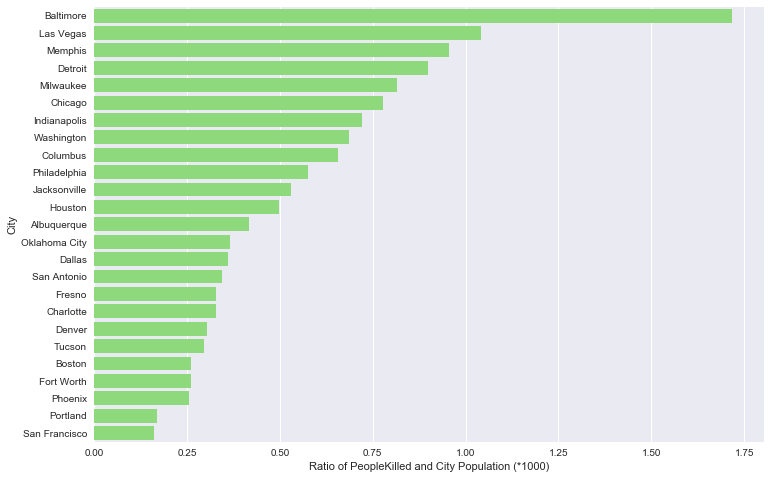

In [10]:
i_p = tempdf.sort_values(['killed_population_ratio'], ascending=[False])
i_p = i_p[i_p['city_population'] > 500000][:25]
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(y='city_or_county', x='killed_population_ratio', data=i_p, color='#85e86d')
ax.set(xlabel='Ratio of PeopleKilled and City Population (*1000)', ylabel='City');

Baltimore novamente está no topo da lista, pois há cerca de 1000 pessoas que foram mortas em incidentes de violência armada e essa proporção é igual a 1,716382. Las Vegas com 632912 e Memphis com o tamanho da população de 652717 vem em segundo e terceiro lugar como 660 e 623 pessoas foram mortas. Sua razão de morte para população é de 1,04 e 0,95. Chicago, onde ocorreram incidentes máximos, o índice de mortalidade por população foi de 0,77, o que vem no sexto lugar

    3.6 Conjunto de dados ajustados à população - Principais cidades (pessoas feridas por 100.000 pessoas)

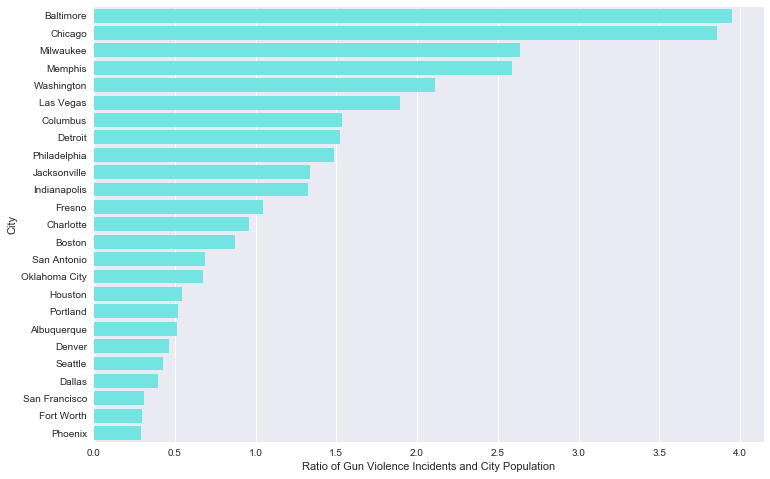

In [11]:
i_p = tempdf.sort_values(['injured_population_ratio'], ascending=[False])
i_p = i_p[i_p['city_population'] > 500000][:25]
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(y='city_or_county', x='injured_population_ratio', data=i_p, color='#60f7f4')
ax.set(xlabel='Ratio of Gun Violence Incidents and City Population', ylabel='City');

Baltmore e Chicago são as cidades com maior proporção de pessoas feridas em incidentes de violência armada e população da cidade. Além destes, Milwaukee, Memphis e Washington são outras cidades importantes onde a proporção de pessoas que se machucam em incidentes de violência armada é bem maior.

4. Outras características dos incidentes de violência armada

    4.1 Número de Armas Usadas (maior que 1)

In [12]:
df['n_guns'] = df['n_guns_involved'].apply(lambda x : "10+" if x>=10 else str(x))

tempdf = df['n_guns'].value_counts().reset_index()
tempdf = tempdf[tempdf['index'] != 'nan']
tempdf = tempdf[tempdf['index'] != '1.0']

labels = list(tempdf['index'])
values = list(tempdf['n_guns'])

trace1 = go.Pie(labels=labels, values=values, marker=dict(colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1', '#c0d1ed', '#efaceb', '#f5f794', '#94f794', '#fcc771']))
layout = dict(height=500, title='Number of Guns Used (More than 1)', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

    4.2 Incidentes de Violência Armada Mais Graves
    
Vamos localizar os incidentes de violência armada mais graves que ocorreram no passado recente. Os incidentes mais graves são defiend pelo número total de mortes e feridos

In [13]:
df1 = df.sort_values(['loss'], ascending=[False])
df1[['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured']].head(10)

,date,state,city_or_county,address,n_killed,n_injured
239677,2017-10-01,Nevada,Las Vegas,Mandalay Bay 3950 Blvd S,59,489
130448,2016-06-12,Florida,Orlando,1912 S Orange Avenue,50,53
217151,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20
101531,2015-12-02,California,San Bernardino,1365 South Waterman Avenue,16,19
232745,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17
70511,2015-05-17,Texas,Waco,4671 S Jack Kultgen Fwy,9,18
195845,2017-07-01,Arkansas,Little Rock,220 W 6th St,0,25
137328,2016-07-25,Florida,Fort Myers,3580 Evans Ave,2,19
11566,2014-04-02,Texas,Fort Hood,Motor Pool Road and Tank Destroyer Boulevard,4,16
92624,2015-10-01,Oregon,Roseburg,1140 Umpqua College Rd,10,9


Vamos traçar os locais desses incidentes no mapa:

In [14]:
smalldf = df[df['n_killed'] >= 3][['latitude', 'longitude', 'loss', 'n_killed']].dropna()
map1 = folium.Map(location=[39.50, -98.35], tiles='CartoDB dark_matter', zoom_start=3.5)
map2 = folium.Map([39.50, -98.35], zoom_start=3.5, tiles='cartodbdark_matter')
markers = []
for i, row in smalldf.iterrows():
    loss = row['loss']
    if row['loss'] > 100:
        loss = row['loss']*0.1    
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(loss), color='#ef4f61', fill=True).add_to(map1)
#     markers.append([float(row['latitude']), float(row['longitude']), row['n_killed']])
# map2.add_child(plugins.HeatMap(markers, radius=12))
map1

Vamos traçar apenas os top 10 principais incidentes:

In [15]:
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]


def returnsize(x):
    if x > 200:
        return 60
    elif x > 80:
        return 40
    elif x > 30:
        return 25
    elif x > 10:
        return 15
    elif x > 5: 
        return 10
    else:
        return 5

df1['size'] = df1['loss'].apply(lambda x: returnsize(x))
dfs = df1.head(50)

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = dfs['longitude'],
        lat = dfs['latitude'],
        text = dfs['city_or_county'],
        mode = 'markers',
        marker = dict(
            size = dfs['size'],
            opacity = 0.5,
            cmin = 0,
        ))]

layout = dict(
        title = 'Most Serious Gun Violence Incidents in US',
        colorbar = True,
        geo = dict(
            projection=dict( type='albers usa' ),
            subunitcolor = "rgb(221, 221, 221)",
            subunitwidth = 1.0
        ),
    )

fig = dict( data=data, layout=layout )
iplot( fig, validate=False)

O tiroteio em Las Vegas foi o mais grave incidente de violência armada, no qual mais de 600 pessoas foram feridas, incluindo 60 assassinatos. Orlando Shootings em 2016, quando cerca de 50 pessoas foram mortas e outros 50 feridos. É outro importante evento de violência armada nos últimos anos. O mais recente tiroteio no Texas em novembro de 2017 foi outro incidente grave, quando mais de 25 pessoas foram mortas.

    4.3 Principais características dos incidentes de violência armada

Vamos entender quais são as principais características dos incidentes de violência armada:

In [16]:
from collections import Counter
big_text = "||".join(df['incident_characteristics'].dropna()).split("||")
incidents = Counter(big_text).most_common(20)
xx = [x[0] for x in incidents]
yy = [x[1] for x in incidents]

trace1 = go.Bar(
    x=yy[::-1],
    y=xx[::-1],
    name='Incident Characterisitcs',
    marker=dict(color='purple'),
    opacity=0.3,
    orientation="h"
)
data = [trace1]
layout = go.Layout(
    barmode='group',
    margin=dict(l=350),
    width=800,
    height=600,
    legend=dict(dict(x=-.1, y=1.2)),
    title = 'Principais características do incidente',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

    4.4 Provável idade para violência por arma de fogo

Vamos descobrir a partir dos dados quais são os principais grupos etários dos suspeitos de violência armada. Os dados não estão diretamente disponíveis, então escrevi um código para obter essas informações combinando várias colunas.


In [17]:
def get_user_mapping(txt):
    if txt == "NA":
        return {}
    mapping = {}
    for d in txt.split("||"):
        try:
            key = d.split("::")[0]
            val = d.split("::")[1]
            if key not in mapping:
                mapping[key] = val
        except:
            pass
    return mapping

df['participant_type'] = df['participant_type'].fillna("NA")
df['participant_type_map'] = df['participant_type'].apply(lambda x : get_user_mapping(x))
df['participant_age'] = df['participant_age'].fillna("NA")
df['participant_age_map'] = df['participant_age'].apply(lambda x : get_user_mapping(x))
df['participant_gender'] = df['participant_gender'].fillna("NA")
df['participant_gender_map'] = df['participant_gender'].apply(lambda x : get_user_mapping(x))

## Finding the Suspect Age Groups
suspect_age_groups = {}
for i, row in df.iterrows():
    suspects = []
    for k,v in row['participant_type_map'].items():
        if "suspect" in v.lower():
            suspects.append(k)
    for suspect in suspects:
        if suspect in row['participant_age_map']:
            ag = row['participant_age_map'][suspect]
            if ag not in suspect_age_groups:
                suspect_age_groups[ag] = 0 
            else:
                suspect_age_groups[ag] += 1

trace1 = go.Bar(x=list(suspect_age_groups.keys()), y=list(suspect_age_groups.values()), opacity=0.75, name="month", marker=dict(color='rgba(200, 20, 160, 0.6)'))
layout = dict(height=400, title='Suspects Age - Distribution', xaxis=dict(range=[0, 100]), legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

Assim, podemos observar que os adolescentes: 18 a 19 anos de idade estão mais envolvidos em incidentes de violência armada, o que é uma visão bastante triste.

    4.5 Idade proeminente das vítimas de violência armada

Da mesma forma, permite traçar quais são as idades das pessoas afetadas nos incidentes de violência armada.

In [18]:
victim_age_groups = {}
for i, row in df.iterrows():
    victims = []
    for k,v in row['participant_type_map'].items():
        if "victim" in v.lower():
            victims.append(k)
    for victim in victims:
        if victim in row['participant_age_map']:
            ag = row['participant_age_map'][victim]
            if ag not in victim_age_groups:
                victim_age_groups[ag] = 0 
            else:
                victim_age_groups[ag] += 1
                
trace1 = go.Bar(x=list(victim_age_groups.keys()), y=list(victim_age_groups.values()), opacity=0.75, name="month", marker=dict(color='brown'))
layout = dict(height=400, title='Victims Age - Distribution', xaxis=dict(range=[0, 100]), legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

    4.6 Grupos de Gênero - Vítimas e Suspeitos
    
Vamos ver a distribuição do gênero de pessoas envolvidas nos incidentes - suspeitos e vítimas:

In [19]:
## find gender groups 
suspect_age_groups = {}
victim_age_groups = {}
for i, row in df.iterrows():
    suspects = []
    for k,v in row['participant_type_map'].items():
        if "suspect" in v.lower():
            suspects.append(k)
    for suspect in suspects:
        if suspect in row['participant_gender_map']:
            ag = row['participant_gender_map'][suspect]
            if ag not in suspect_age_groups:
                suspect_age_groups[ag] = 0 
            else:
                suspect_age_groups[ag] += 1
                        
    victims = []
    for k,v in row['participant_type_map'].items():
        if "victim" in v.lower():
            victims.append(k)
    for victim in victims:
        if victim in row['participant_gender_map']:
            ag = row['participant_gender_map'][victim]
            if ag not in victim_age_groups:
                victim_age_groups[ag] = 0 
            else:
                victim_age_groups[ag] += 1
                
del victim_age_groups['Male, female']
fig = {
  "data": [
    {
      "values": list(suspect_age_groups.values()),
      "labels": list(suspect_age_groups.keys()),
      "marker" : dict(colors=['#fc76bb','#b4a9f9']),
      "name": "Suspects",
      "domain": {"x": [0, .48]},
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    {
      "values": list(victim_age_groups.values()),
      "labels": list(victim_age_groups.keys()),
      "text": ["Victims"],
      "marker" : dict(colors=['#b4a9f9','#fc76bb']),
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Victims",
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    }],
  "layout": {
          "showlegend" : False,
        "title":"Genders of People Involved",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Suspects",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Victims",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='donut')

5. Análise do Número de Armas Registradas por Estado

Mais armas significam mais incidentes de violência armada?

De acordo com o Washington Post, existem mais de 350 milhões de armas nos EUA. Será interessante ver se há mais incidentes de violência armada em estados onde o número de armas per capita também é maior e vice-verca. Eu obtive os dados para o ano de 2017 da seguinte fonte. Consiste em dados sobre guns_per_capita o total de armas registradas por estado.

Referência - Uma análise semelhante foi feita por motherjones em dados para o ano de 2013.

Fonte de dados - https://www.thoughtco.com/gun-owners-percentage-of-state-populations-3325153

In [20]:
from io import StringIO

ownership = StringIO("""Rank,state,guns_per_capita,guns_registered
1,Wyoming,229.24,132806
2,Washington D.C.,68.05,47228
3,New Hampshire,46.76,64135
4,New Mexico,46.73,97580
5,Virginia,36.34,307822
6,Alabama,33.15,161641
7,Idaho,28.86,49566
8,Arkansas,26.57,79841
9,Nevada,25.64,76888
10,Arizona,25.61,179738
11,Louisiana,24.94,116831
12,South Dakota,24.29,21130
13,Utah,23.48,72856
14,Connecticut,22.96,82400
15,Alaska,21.38,15824
16,Montana,21.06,22133
17,South Carolina,21.01,105601
18,Texas,20.79,588696
19,West Virginia,19.42,35264
20,Pennsylvania,18.45,236377
21,Georgia,18.22,190050
22,Kentucky,18.2,81068
23,Oklahoma,18.13,71269
24,Kansas,18.06,52634
25,North Dakota,17.56,13272
26,Indiana,17.1,114019
27,Maryland,17.03,103109
28,Colorado,16.48,92435
29,Florida,16.35,343288
30,Ohio,14.87,173405
31,North Carolina,14.818,152238
32,Oregon,14.816,61383
33,Tennessee,14.76,99159
34,Minnesota,14.22,79307
35,Washington,12.4,91835
36,Missouri,11.94,72996
37,Mississippi,11.89,35494
38,Nebraska,11.57,22234
39,Maine,11.5,15371
40,Illinois,11.44,146487
41,Wisconsin,11.19,64878
42,Vermont,9.41,5872
43,Iowa,9.05,28494
44,California,8.71,344622
45,Michigan,6.59,65742
46,New Jersey,6.38,57507
47,Hawaii,5.5,7859
48,Massachusetts,5.41,37152
49,Delaware,5.04,4852
50,Rhode Island,3.98,37152
51,New York,3.83,76207""")

ownership = pd.read_csv(ownership)

states_df = df[df['year'] == 2017]['state'].value_counts()
statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values
statesdf = statesdf.merge(ownership, on='state')

data = [
    {
        'x': statesdf['guns_per_capita'],
        'y': statesdf['counts'],
        'mode': 'markers',
        'text' : statesdf['state'],
        'marker': {
            'color': statesdf['Rank'],
            'size': 15,
            'showscale' : True,
            'colorscale' : 'Earth',
            "colorbar" : dict(
                title='Rank (guns_per_capita)'
            ),
            'opacity': 0.9
        }
    }
]

layout = go.Layout(title="Guns Per Capita Vs GunViolence Incidents by State (2017)", 
                   xaxis=dict(title='Total Guns Registered Per Capita'),
                   yaxis=dict(title='Gun Violence Incidents')
                  
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

De acordo com esses dados, Wyoming tinha o maior número de armas registradas per capita igual a 229, no entanto, houve apenas 91 incidentes de violência armada em 2017. Estados como Califórnia, Illinois e Flordia podem ter menor número de armas registradas per capita mas o número de incidentes foi bem maior, como podemos ver no canto superior esquerdo do gráfico acima.

Vamos ampliar o gráfico e visualizar os estados depois de remover alguns outliers, como Wyoming, Califórnia, Illinois e Flórida.


In [21]:
#### zooomed in 

data = [
    {
        'x': statesdf['guns_per_capita'],
        'y': statesdf['counts'],
        'mode': 'markers',
        'text' : statesdf['state'],
        'marker': {
            'color': statesdf['Rank'],
            'size': 15,
            'showscale' : True,
            'colorscale' : 'Earth',
            "colorbar" : dict(
                title='Rank (guns_per_capita)'
            ),
            'opacity': 0.9
        }
    }
]

layout = go.Layout(title="Zoomed - Guns Per Capita Vs GunViolence Incidents by State (2017)", 
                   xaxis=dict(title='Total Guns Registered Per Capita', range =[0, 50]),
                   yaxis=dict(title='Gun Violence Incidents', range=[0, 3000])
                   
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

Vamos traçar o número total de armas registradas em vez de armas per capita:

In [22]:
data = [
    {
        'x': statesdf['guns_registered'],
        'y': statesdf['counts'],
        'mode': 'markers',
        'text' : statesdf['state'],
        'marker': {
            'color': statesdf['Rank'],
            'size': 15,
            'showscale' : True,
            'colorscale' : 'Picnic',
            "colorbar" : dict(
                title='Rank (guns_per_capita)'
            ),
            'opacity': 0.9
        }
    }
]


layout = go.Layout(title="Total Guns Registered Vs GunViolence Incidents by State (2017)", 
                   xaxis=dict(title='Total Guns Registered'),
                   yaxis=dict(title='Gun Violence Incidents'))
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

Assim, podemos ver que as pessoas no Texas possuem o maior número de armas em toda a América, mas o número de incidentes é muito maior em alguns outros estados. Mas os números da Califórnia e da Flórida sugerem que um maior número de armas pertence a um maior número de incidentes de violência armada.

    6. O impacto das leis de armas em incidentes de violência armada

Outra métrica a ser analisada será quão rigorosas são as leis de armas em diferentes estados, e como elas se correlacionam com o número de incidentes de violência armada nesses estados. Tomei os dados das leis de armas nos anos seguintes: 2014, 2015, 2016, 2017 da seguinte fonte:

Fonte: https://statefirearmlaws.org/national-data/

    6.1 Aumento das leis de violência armada em diferentes estados: 2014 - 2018

In [23]:
state_to_code = {'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI', 'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 'Nevada': 'NV', 'Maine': 'ME'}
laws_2014 = {'Mississippi': 5, 'Oklahoma': 9, 'Delaware': 38, 'Minnesota': 39, 'Illinois': 65, 'Arkansas': 11, 'New Mexico': 10, 'Ohio': 15, 'Indiana': 11, 'Maryland': 63, 'Louisiana': 12, 'Texas': 20, 'Wyoming': 6, 'Tennessee': 24, 'Arizona': 8, 'Wisconsin': 24, 'Michigan': 20, 'Kansas': 8, 'Utah': 11, 'Virginia': 12, 'Oregon': 24, 'Connecticut': 85, 'Montana': 4, 'California': 100, 'Idaho': 5, 'West Virginia': 24, 'South Carolina': 12, 'New Hampshire': 10, 'Massachusetts': 101, 'Vermont': 3, 'Georgia': 6, 'North Dakota': 14, 'Pennsylvania': 37, 'Florida': 21, 'Alaska': 3, 'Kentucky': 7, 'Hawaii': 78, 'Nebraska': 22, 'Missouri': 8, 'Iowa': 25, 'Alabama': 10, 'Rhode Island': 43, 'South Dakota': 5, 'Colorado': 30, 'New Jersey': 67, 'Washington': 41, 'North Carolina': 30, 'New York': 76, 'Nevada': 11, 'Maine': 11}
laws_2015 = {'Mississippi': 2, 'Oklahoma': 9, 'Delaware': 38, 'Minnesota': 41, 'Illinois': 65, 'Arkansas': 11, 'New Mexico': 10, 'Ohio': 16, 'Indiana': 11, 'Maryland': 64, 'Louisiana': 12, 'Texas': 20, 'Wyoming': 6, 'Tennessee': 24, 'Arizona': 8, 'Wisconsin': 23, 'Michigan': 21, 'Kansas': 4, 'Utah': 11, 'Virginia': 12, 'Oregon': 33, 'Connecticut': 85, 'Montana': 4, 'California': 102, 'Idaho': 6, 'West Virginia': 24, 'South Carolina': 12, 'New Hampshire': 10, 'Massachusetts': 101, 'Vermont': 6, 'Georgia': 6, 'North Dakota': 14, 'Pennsylvania': 37, 'Florida': 21, 'Alaska': 3, 'Kentucky': 7, 'Hawaii': 78, 'Nebraska': 22, 'Missouri': 8, 'Iowa': 25, 'Alabama': 10, 'Rhode Island': 43, 'South Dakota': 5, 'Colorado': 30, 'New Jersey': 67, 'Washington': 41, 'North Carolina': 30, 'New York': 76, 'Nevada': 15, 'Maine': 11}
laws_2016 = {'Mississippi': 2, 'Oklahoma': 9, 'Delaware': 39, 'Minnesota': 41, 'Illinois': 65, 'Arkansas': 11, 'New Mexico': 10, 'Ohio': 16, 'Indiana': 12, 'Maryland': 64, 'Louisiana': 12, 'Texas': 18, 'Wyoming': 6, 'Tennessee': 22, 'Arizona': 8, 'Wisconsin': 23, 'Michigan': 21, 'Kansas': 4, 'Utah': 11, 'Virginia': 13, 'Oregon': 35, 'Connecticut': 90, 'Montana': 4, 'California': 104, 'Idaho': 2, 'West Virginia': 18, 'South Carolina': 12, 'New Hampshire': 10, 'Massachusetts': 101, 'Vermont': 6, 'Georgia': 6, 'North Dakota': 14, 'Pennsylvania': 37, 'Florida': 21, 'Alaska': 3, 'Kentucky': 7, 'Hawaii': 79, 'Nebraska': 22, 'Missouri': 7, 'Iowa': 25, 'Alabama': 10, 'Rhode Island': 43, 'South Dakota': 5, 'Colorado': 30, 'New Jersey': 67, 'Washington': 43, 'North Carolina': 30, 'New York': 76, 'Nevada': 15, 'Maine': 11}
laws_2017 = {'Mississippi': 2, 'Oklahoma': 9, 'Delaware': 40, 'Minnesota': 41, 'Illinois': 65, 'Arkansas': 11, 'New Mexico': 10, 'Ohio': 16, 'Indiana': 12, 'Maryland': 64, 'Louisiana': 13, 'Texas': 18, 'Wyoming': 6, 'Tennessee': 22, 'Arizona': 8, 'Wisconsin': 23, 'Michigan': 21, 'Kansas': 4, 'Utah': 13, 'Virginia': 13, 'Oregon': 35, 'Connecticut': 90, 'Montana': 4, 'California': 106, 'Idaho': 2, 'West Virginia': 18, 'South Carolina': 12, 'New Hampshire': 9, 'Massachusetts': 101, 'Vermont': 6, 'Georgia': 6, 'North Dakota': 10, 'Pennsylvania': 37, 'Florida': 21, 'Alaska': 3, 'Kentucky': 7, 'Hawaii': 79, 'Nebraska': 22, 'Missouri': 2, 'Iowa': 24, 'Alabama': 10, 'Rhode Island': 53, 'South Dakota': 5, 'Colorado': 30, 'New Jersey': 75, 'Washington': 43, 'North Carolina': 30, 'New York': 76, 'Nevada': 21, 'Maine': 11}

y1, y2, y3, y4 = [], [], [], []
x1 = []
for x, y in laws_2014.items():
    y1.append(y)
    y2.append(laws_2015[x])
    y3.append(laws_2016[x])
    y4.append(laws_2017[x])
    x1.append(x)

trace1 = go.Bar(x=x1,y=y1,name='2014', marker=dict(color="#f27da6"))
trace2 = go.Bar(x=x1,y=y2,name='2015', marker=dict(color="#7f9bef"))
trace3 = go.Bar(x=x1,y=y3,name='2016', marker=dict(color="#94e8ba"))
trace4 = go.Bar(x=x1,y=y4,name='2017', marker=dict(color="#e8d54a"))

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(barmode='group', title="Rise of Gun Violence Laws : 2014 - 2017")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

6.2 Impacto do Número de Leis de Armas vs. Incidentes de Violência Armada: 2014 - 2017

Vamos analisar o número de leis de violência armada e os incidentes de violência armada em diferentes estados ao longo desses anos.

In [24]:
states_df = df[df['year'] == 2015]['state'].value_counts()
statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values
statesdf['laws'] = statesdf['state'].apply(lambda x : laws_2015[x] if x in laws_2015 else "")

statesdf['state'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [
    {
        'x': statesdf['laws'],
        'y': statesdf['counts'],
        'mode': 'markers+text',
        'text' : statesdf['state'],
        'textposition' : 'bottom center',
        'marker': {
            'color': "#d889f9",
            'size': 15,
            'opacity': 0.9
        }
    }
]

layout = go.Layout(title="Gun Laws vs Gun Violence Incidents - 2015", 
                   xaxis=dict(title='Total Gun Laws'),
                   yaxis=dict(title='Gun Violence Incidents')
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

In [25]:
states_df = df[df['year'] == 2016]['state'].value_counts()
statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values
statesdf['laws'] = statesdf['state'].apply(lambda x : laws_2016[x] if x in laws_2016 else "")

statesdf['state'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [
    {
        'x': statesdf['laws'],
        'y': statesdf['counts'],
        'mode': 'markers+text',
        'text' : statesdf['state'],
        'textposition' : 'bottom center',
        'marker': {
            'color': "#f27da6",
            'size': 15,
            'opacity': 0.9
        }
    }
]

layout = go.Layout(title="Gun Laws vs Gun Violence Incidents - 2016", 
                   xaxis=dict(title='Total Gun Laws'),
                   yaxis=dict(title='Gun Violence Incidents')
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

In [26]:
states_df = df[df['year'] == 2017]['state'].value_counts()
statesdf = pd.DataFrame()
statesdf['state'] = states_df.index
statesdf['counts'] = states_df.values
statesdf['laws'] = statesdf['state'].apply(lambda x : laws_2017[x] if x in laws_2017 else "")

statesdf['state'] = statesdf['state'].apply(lambda x : state_to_code[x])

data = [
    {
        'x': statesdf['laws'],
        'y': statesdf['counts'],
        'mode': 'markers+text',
        'text' : statesdf['state'],
        'textposition' : 'bottom center',
        'marker': {
            'color': "#42f4bc",
            'size': 15,
            'opacity': 0.9
        }
    }
]

layout = go.Layout(title="Gun Laws vs Gun Violence Incidents - 2017", 
                   xaxis=dict(title='Total Gun Laws'),
                   yaxis=dict(title='Gun Violence Incidents')
                  )
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='scatter-colorscale')

Os estados da Califórnia, Massachusetts, Havaí, Nova York, New Jersy, Illinois, MaryLand e Rhode Island têm um número consideravelmente maior de leis sobre a violência armada. Entre eles, apenas Califórnia e Illinois têm o maior número de incidentes de violência armada. Estados como o Texas e a Flórida têm um número consideravelmente menor de leis sobre a violência armada, mas um alto número de incidentes.